# Debugging, Evaluating, and Monitoring LLM Apps using LangSmith
* Notebook by Adam Lang
* Date: 11/8/24

# Overview
* In this notebook we will run an end-to-end evaluation of LLM application using LangSmith observability and tracing.

# Install dependencies

In [3]:
!pip install langchain==0.2.0
!pip install langchain-openai==0.1.7
!pip install langchain-community==0.2.0
!pip install langsmith==0.1.71

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 973.7/973.7 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 397.1/397.1 kB 25.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.1 MB/s eta 0:00:00
  Attempting uninstall: tenacity
    Found existing installation: tenacity 9.0.0
    Uninstalling tenacity-9.0.0:
      Successfully uninstalled tenacity-9.0.0
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.13
    Uninstalling langchain-core-0.3.13:
      Successfully uninstalled langchain-core-0.3.13
  Attempting uninstall: langchain-text-splitters
    Found existing installation: langchain-text-splitters 0.3.0
    Uninstalling langchain-text-splitters-0.3.0:
      Successfully uninstalled langchain-text-splitters-0.3.0
  Attempting uninstall: langchain
    Found existing installation: langchain 0.3.4
    Uninstalling langchain-0.3.4:
      Successfully uninstalled langchain-0.3.4
   ━━━━━━━━━━━━━━━━━━━━━━

# Enter Open AI API Key

In [4]:
from getpass import getpass

OPENAI_KEY = getpass('Enter Open AI API key: ')

Enter Open AI API key: ··········


# Enter LangSmith API Key

In [5]:
from getpass import getpass

LANGSMITH_KEY = getpass('Enter LangSmith API Key: ')

Enter LangSmith API Key: ··········


# Setup Environment Variables

In [6]:
import os

os.environ['OPENAI_API_KEY'] = OPENAI_KEY
os.environ['LANGCHAIN_TRACING_V2'] = "true"

## change this based on apps and project needs
os.environ['LANGCHAIN_PROJECT'] = f"My LLM App Project"
os.environ['LANGCHAIN_ENDPOINT'] = "https://api.smith.langchain.com" ## stores all app traces
os.environ['LANGCHAIN_API_KEY'] = LANGSMITH_KEY ## langsmith API key

# Debugging and Monitoring of LLM Apps using LangSmith
* Here we can look at different ways to evaluate LLM apps which are also called "Runs".
* Collections of runs make up a trace.
  * A Trace is a series of steps that your LLM application takes to go from input to output.
  * Each of these individual steps is represented by a Run.
* A project is a collection of Traces.
* Example:

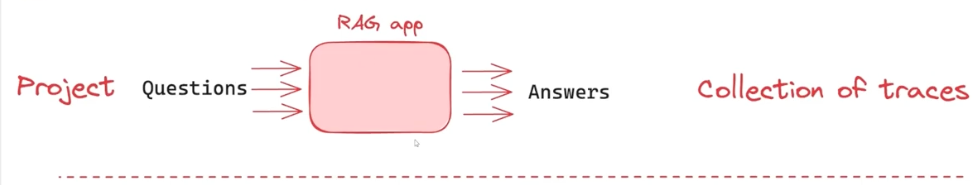

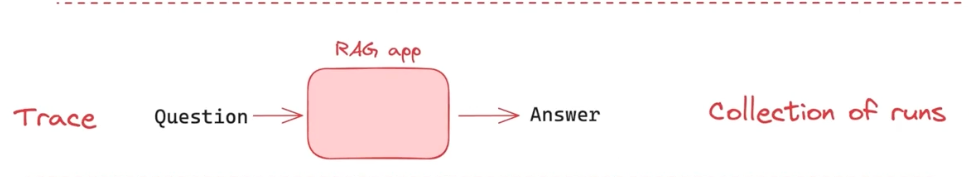

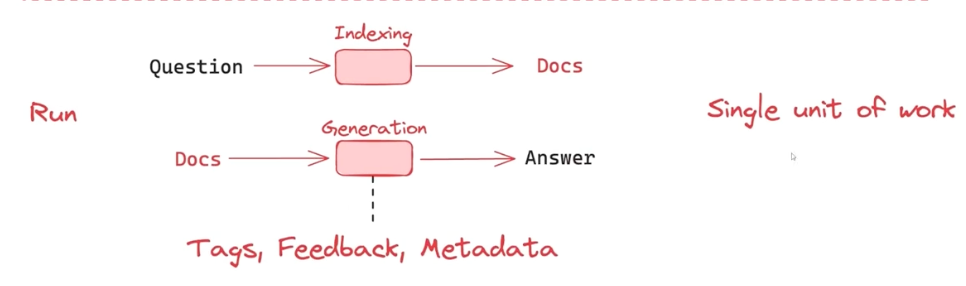

# Monitor LLM App Traces with LangSmith
* To demo this we will create a "basic" LLM application.

In [7]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI

# config the chat prompt template and define llm chain
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", "Act as a helpful AI Assistant"),
        ("human", "{human_input}"),
    ]
)

## Initialize the OpenAI Chat instance with specific model params
chatgpt = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0)

# create simple llm chain
llm_chain = (prompt
                |
             chatgpt
                |
             StrOutputParser()

             )


In [8]:
## prompt input
prompt_txt = "Explain machine learning in 3 bullet points."
response = llm_chain.invoke({'human_input': prompt_txt})
print(response)

- Machine learning is a subset of artificial intelligence that involves developing algorithms and models that enable computers to learn from and make predictions or decisions based on data.
- It involves training a model on a dataset to recognize patterns and relationships, allowing it to make predictions or decisions on new, unseen data.
- Machine learning algorithms can be categorized into supervised learning, unsupervised learning, and reinforcement learning, each with its own approach to learning from data.


## Selective Tracing
* You would selectively trace when you only want to monitor specific tasks of your application.

In [9]:
os.environ['LANGCHAIN_TRACING_V2'] = "false"

In [10]:
## does not get traced anymore
prompt_txt = "Explain machine learning in one line."
response = llm_chain.invoke({'human_input': prompt_txt})
print(response)

Machine learning is a branch of artificial intelligence that enables systems to learn and improve from experience without being explicitly programmed.


In [11]:
from langchain.callbacks.tracers import LangChainTracer

# You can configure a LangChainTracer instance to trace a specific invocation.
tracer = LangChainTracer()
prompt_txt = "Explain machine learning in one line."
## below code will invoke trace to be tracked in LangSmith
response = llm_chain.invoke({'human_input': prompt_txt}, config={"callbacks": [tracer]})
print(response)

Machine learning is a branch of artificial intelligence that enables systems to learn and improve from experience without being explicitly programmed.


In [12]:
# LangChain also supports a context manager for tracing a specific block of code
from langchain_core.tracers.context import tracing_v2_enabled

## prompt text
prompt_txt = "Explain machine learning in one line."
with tracing_v2_enabled():
  response = llm_chain.invoke({'human_input': prompt_txt})
  print(response)

Machine learning is a subset of artificial intelligence that enables systems to learn and improve from experience without being explicitly programmed.


## Log traces to specific projects dynamically
* One way to do that is to use the `LangChainTracer` and use the `project_name` function.
* Another way to do this is to utilize the `tracing_v2_enabled` scope function.

In [13]:
tracer = LangChainTracer(project_name="My LLM App Project - Test")
prompt_txt = "Explain Data Science in one line."
response = llm_chain.invoke({'human_input': prompt_txt}, config={'callbacks': [tracer]})
print(response)

Data Science is the field of extracting insights and knowledge from data using various techniques and tools.


In [14]:
## another way to do this
prompt_txt = "Explain data science in one line"
with tracing_v2_enabled(project_name="My LLM App Project - Test"):
  response = llm_chain.invoke({'human_input': prompt_txt})
  print(response)

Data science is a multidisciplinary field that uses scientific methods, algorithms, and systems to extract knowledge and insights from structured and unstructured data.


Output is below:
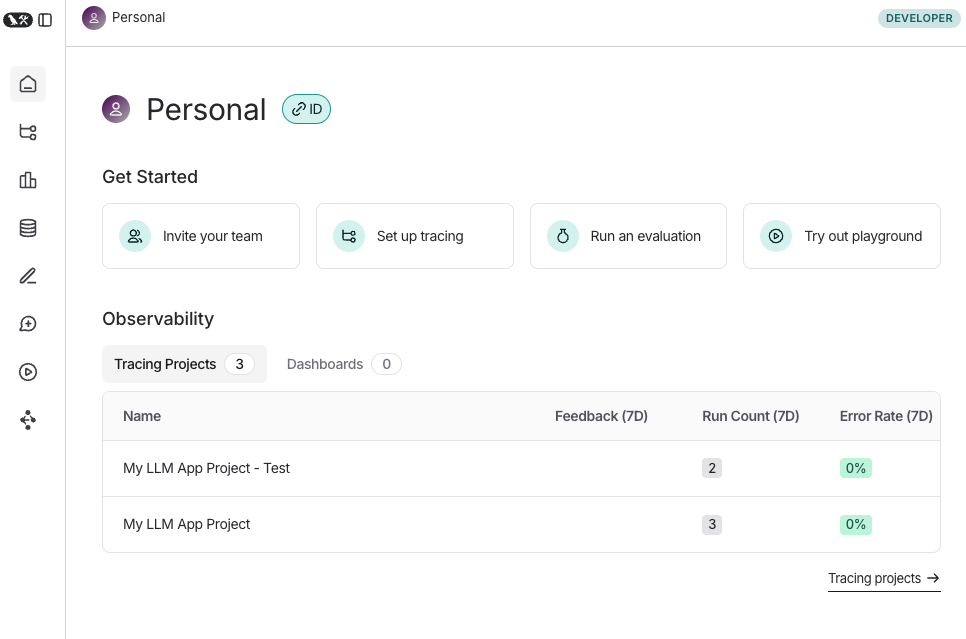

## Adding metadata and tags in traces
* You can add additional details using metadata.

In [15]:
prompt_txt = "Explain data science in one line."
with tracing_v2_enabled():
  response = llm_chain.invoke({'human_input': prompt_txt}, {'tags': ['AI', 'Data Science'],
                                                            "metadata": {'user': "al", "team": "data science"}}) ## can add specific user and team

  print(response)

Data science is a multidisciplinary field that uses scientific methods, algorithms, and systems to extract knowledge and insights from structured and unstructured data.


In [16]:
prompt_txt = "Tell me which animal is the slowest on land?"
with tracing_v2_enabled():
  response = llm_chain.invoke({'human_input': prompt_txt}, {'tags': ['General Knowledge', 'Environment'],
                                                            "metadata": {'user': "tom", "team": "social sciences"}}) ## can add specific user and team

  print(response)

The slowest animal on land is the sloth. Sloths are known for their slow movements and can travel at a speed of about 0.24 kilometers per hour (0.15 miles per hour) on the ground.


We can see the metadata is now logged:
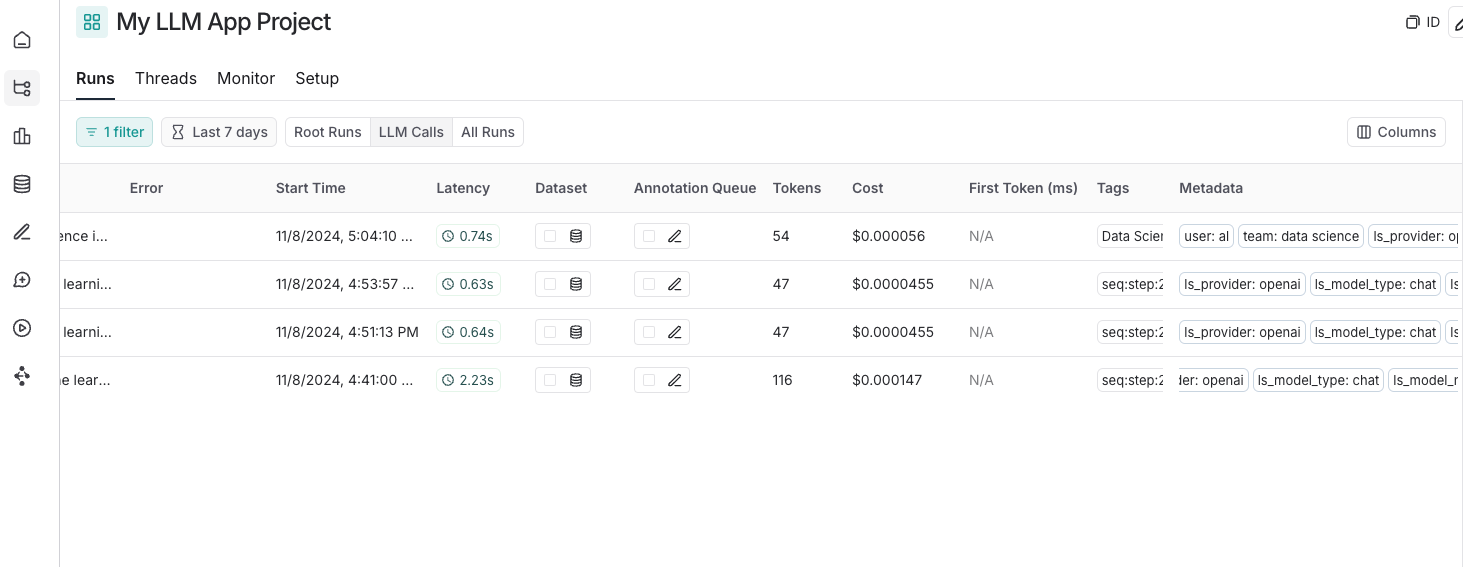

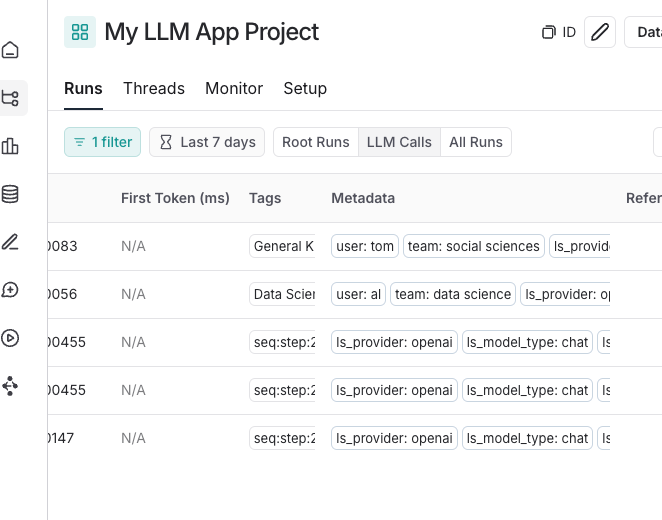

## Customize run names

In [17]:
prompt_txt = "Explain to me what is Deep Learning?"
with tracing_v2_enabled():
  response = llm_chain.invoke({'human_input': prompt_txt}, {'tags': ['AI','Data Science'],
                                                            "metadata": {"user": "al", "team": "data science"},
                                                            "run_name": "ALRunNov2024_001"},

                              )
  print(response)

Deep learning is a subset of machine learning that involves training artificial neural networks to learn and make decisions in a way that mimics the human brain. These neural networks are composed of multiple layers of interconnected nodes, which process and analyze data to extract patterns and make predictions.

Deep learning algorithms are capable of automatically learning representations of data through a process of feature extraction, without the need for explicit programming. This allows them to handle complex tasks such as image and speech recognition, natural language processing, and more.

Deep learning has been widely used in various fields such as computer vision, speech recognition, healthcare, finance, and many others, due to its ability to achieve high levels of accuracy and performance in tasks that were previously considered challenging for traditional machine learning algorithms.


# Creating an Evaluation Dataset for eval and monitoring in LangSmith
* Then we will look at all the ways you can evaluate an application with LangSmith.

In [18]:
os.environ['OPENAI_API_KEY'] = OPENAI_KEY
os.environ['LANGCHAIN_TRACING_V2'] = "true"

## change this based on apps and project needs
os.environ['LANGCHAIN_PROJECT'] = f"My LLM App Project"
os.environ['LANGCHAIN_ENDPOINT'] = "https://api.smith.langchain.com" ## stores all app traces
os.environ['LANGCHAIN_API_KEY'] = LANGSMITH_KEY ## langsmith API key

## Access LLM App runs

In [19]:
from langsmith import Client

In [20]:
from datetime import datetime, timedelta

# Initialize a client
client = Client(timeout_ms=3600000)

todays_llm_runs = client.list_runs(
    project_name="My LLM App Project",
    start_time=datetime.now() - timedelta(days=1), # can change or remove this to retrieve more runs
    run_type="llm",
)

In [21]:
## create a dataset to store the runs
dataset = []
for run in todays_llm_runs:
  dataset.append((run.inputs, run.outputs))

In [34]:
## view index 0
dataset

[({'messages': [[{'lc': 1,
      'type': 'constructor',
      'id': ['langchain', 'schema', 'messages', 'SystemMessage'],
      'kwargs': {'content': 'Act as a helpful AI Assistant',
       'type': 'system'}},
     {'lc': 1,
      'type': 'constructor',
      'id': ['langchain', 'schema', 'messages', 'HumanMessage'],
      'kwargs': {'content': 'Explain to me what is Deep Learning?',
       'type': 'human'}}]]},
  None),
 ({'messages': [[{'lc': 1,
      'type': 'constructor',
      'id': ['langchain', 'schema', 'messages', 'SystemMessage'],
      'kwargs': {'content': 'Act as a helpful AI Assistant',
       'type': 'system'}},
     {'lc': 1,
      'type': 'constructor',
      'id': ['langchain', 'schema', 'messages', 'HumanMessage'],
      'kwargs': {'content': 'Tell me which animal is the slowest on land?',
       'type': 'human'}}]]},
  {'generations': [[{'text': 'The slowest animal on land is the sloth. Sloths are known for their slow movements and can travel at a speed of about 0.2

# Create eval dataet of inputs and outputs
* Ideally outputs should be **human-labeled or annotated outputs** which are examples of **ground-truth** for input data.
* Here though we will just use model outputs to quickly create eval dataset.

In [ ]:
refined_dataset = []
for input, output in dataset:
    refined_dataset.append((input['messages'][1]['kwargs']['content'],
                            output['generations'][0]['text']))
refined_dataset = list(set(refined_dataset))
refined_dataset

In [ ]:
refined_dataset

Adding human-labaled input-output examples

In [ ]:
more_examples = [
  ("What is the largest mammal?", "The blue whale"),
  ("What do mammals and birds have in common?", "Both are homeothermic (warm-blooded) animals"),
  ("What's the main characteristic of amphibians?", "They live both in water and on land"),
]

for input, output in more_examples:
    refined_dataset.append((input, output))

refined_dataset

# Create Eval Dataset in LangSmith
* Here we can upload our dataset to LangSmith and create and eval dataset.

In [37]:
# Initialize a client
client = Client(timeout_ms=3600000)

# Storing inputs in a dataset lets us
# run chains and LLMs over a shared set of examples.
dataset = client.create_dataset(
    dataset_name='Sample LLM App Eval Dataset - ALTest001',
    description="Dataset of sample prompts and human outputs",
)
dataset

Dataset(name='Sample LLM App Eval Dataset - ALTest001', description='Dataset of sample prompts and human outputs', data_type=<DataType.kv: 'kv'>, id=UUID('79aea0d2-83a0-47c8-aada-431fffaea667'), created_at=datetime.datetime(2024, 11, 9, 1, 19, 39, 112374, tzinfo=datetime.timezone.utc), modified_at=datetime.datetime(2024, 11, 9, 1, 19, 39, 112374, tzinfo=datetime.timezone.utc), example_count=0, session_count=0, last_session_start_time=None)

In [38]:
for input_prompt, output_answer in refined_dataset:
    client.create_example(
        inputs={"question": input_prompt},
        outputs={"answer": output_answer},
        metadata={"source": "Wikipedia"},
        dataset_id=dataset.id,
    )

In [39]:
datasets = client.list_datasets()
list(datasets)

[Dataset(name='Sample LLM App Eval Dataset - ALTest001', description='Dataset of sample prompts and human outputs', data_type=<DataType.kv: 'kv'>, id=UUID('79aea0d2-83a0-47c8-aada-431fffaea667'), created_at=datetime.datetime(2024, 11, 9, 1, 19, 39, 112374, tzinfo=datetime.timezone.utc), modified_at=datetime.datetime(2024, 11, 9, 1, 19, 39, 112374, tzinfo=datetime.timezone.utc), example_count=0, session_count=0, last_session_start_time=None)]

# View evaluation dataset examples
* We can get examples of data points from eval dataset anytime.

In [40]:
examples = client.list_examples(dataset_name="Sample LLM App Eval Dataset - ALTest001")

In [41]:
for examples in examples:
  print(example)

# Evaluate and Monitor LLM App Performance

In [ ]:
from langsmith.evaluation import evaluate

# Initialize a client
client = Client(timeout_ms=3600000)

results = evaluate(
    lambda x: llm_chain.invoke({'human_input' : x['question']}),
    client=client,
    data="Sample LLM App Eval Dataset - ALTest001",
    experiment_prefix="test_eval001",
)

In [ ]:
from langsmith.evaluation import LangChainStringEvaluator, evaluate

qa_evaluator = LangChainStringEvaluator("qa")

# Initialize a client
client = Client(timeout_ms=3600000)

results = evaluate(
    lambda x: llm_chain.invoke({'human_input' : x['question']}),
    client=client,
    data="Sample LLM App Eval Dataset - ALTest001",
    experiment_prefix="test_eval001",
    evaluators=[qa_evaluator]
)

In [ ]:
correct_evaluator = LangChainStringEvaluator("labeled_criteria",
                                             config={ "criteria": "correctness"})
conciseness_evaluator =LangChainStringEvaluator("criteria",
                                                config={ "criteria": "conciseness"})
helpfulness_evaluator = LangChainStringEvaluator("criteria",
                                                 config={ "criteria": "helpfulness"})
semantic_evaluator = LangChainStringEvaluator("embedding_distance")

# Initialize a client
client = Client(timeout_ms=3600000)

results = evaluate(
    lambda x: llm_chain.invoke({'human_input' : x['question']}),
    client=client,
    data="Sample LLM App Eval Dataset - ALTest001",
    experiment_prefix="test_eval001",
    evaluators=[correct_evaluator, conciseness_evaluator,
                semantic_evaluator, helpfulness_evaluator]
)